Build a model to perform Mask Image classification

Ensure that Google CoLab is running the correct version of TensorFlow.

In [1]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Note: using Google CoLab


Mount the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Go to the directory

In [3]:
%cd /content/drive/My Drive/
!ls

/content/drive/My Drive
Model  MyImage	Object


Import the needed library

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random


2. 0 Data Cleaning. 

Do variable initialization

In [5]:
tf.random.set_seed(12345678)

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
data_dir= "Object"

2.1 Setup the training data and testing data. Training Data 70%, Testing Data 30%

In [8]:
!ls

Model  MyImage	Object


In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1510 files belonging to 2 classes.
Using 1057 files for training.


In [10]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1510 files belonging to 2 classes.
Using 453 files for validation.


2.2 Display the class type

In [11]:
class_names = train_dataset.class_names
print(class_names)

['Mask', 'NoMask']


2.3 Display the desired images

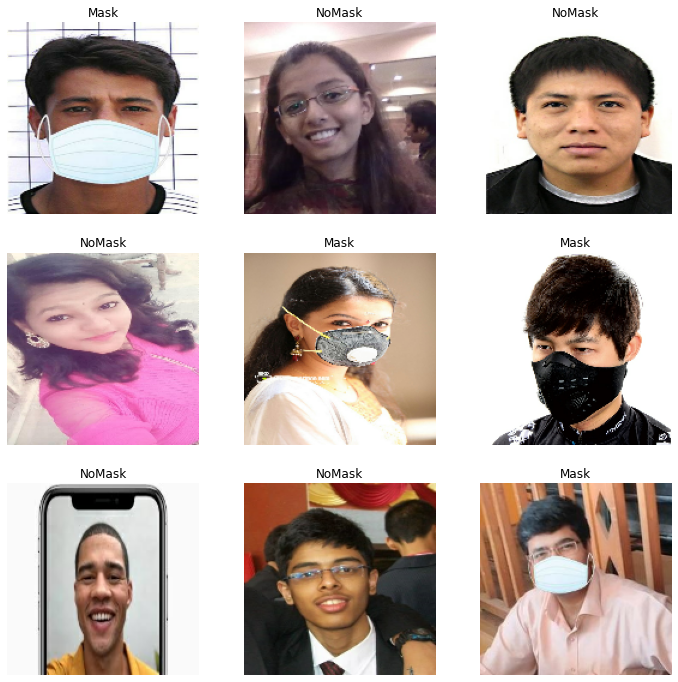

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

2.4 Set a small sample aside to test the model (test_dataset). This will be 20% of the validation_dataset

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 34
Number of validation batches: 12
Number of test batches: 3



2.5 Use dataset.prefetch in the 3 splits. to avoid overlapping during the training process


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

3. Prepare the base model

3.1 Data augmentation. 

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Show the result of the image augmentation

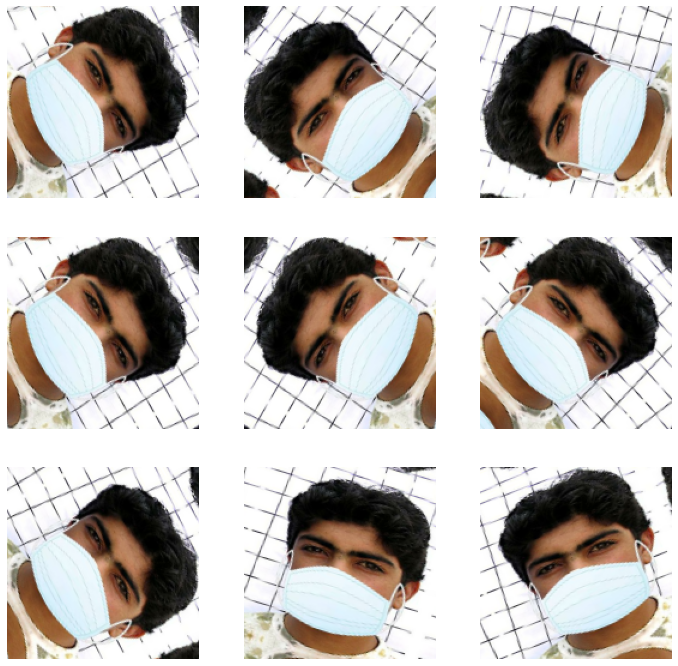

In [17]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

3.2 Rescale the pixel values

Do knowledge tranfer from  mobile.net 

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

The model expect value 0 and 1. Input need to be preprocessed.

In [19]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

3.3 Create base model for mobile.net

Include include_top= false so that the classification layer created by mobile.net will be included.

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor convert images from 160x160x3 to 5 x 5 x 1280

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature Extraction

Freeze the convolutional base created from the previous step, because it is going to be used as a feature extractor

In [22]:
base_model.trainable = False

Adding classification head

The layer tf.keras.layers.GlobalAveragePooling2D is used to convert the features in a 1280-element vector, per each image

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense is a layer that converts the features into a single prediction

In [24]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Apply the previous process to the model:

*   Rescaling
*   Data Augmentation
*   Base Model
*   Feature Extractor


In [25]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compilation of the model

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

There are two variable objects. Divided between MobilNet parameters which are frozen, and  trainable parameter in the Dense layer

In [28]:
len(model.trainable_variables)

2

Train the model

In [29]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 3s 34ms/step - loss: 0.7896 - accuracy: 0.5574


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.56


In [31]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
34/34 [==============================] - 7s 108ms/step - loss: 0.7968 - accuracy: 0.6026 - val_loss: 0.6307 - val_accuracy: 0.7115
Epoch 2/10
34/34 [==============================] - 4s 107ms/step - loss: 0.6831 - accuracy: 0.6755 - val_loss: 0.5499 - val_accuracy: 0.7171
Epoch 3/10
34/34 [==============================] - 4s 106ms/step - loss: 0.5867 - accuracy: 0.7077 - val_loss: 0.4758 - val_accuracy: 0.7507
Epoch 4/10
34/34 [==============================] - 4s 106ms/step - loss: 0.5314 - accuracy: 0.7313 - val_loss: 0.4320 - val_accuracy: 0.7843
Epoch 5/10
34/34 [==============================] - 4s 106ms/step - loss: 0.4465 - accuracy: 0.7824 - val_loss: 0.3768 - val_accuracy: 0.8459
Epoch 6/10
34/34 [==============================] - 4s 106ms/step - loss: 0.4377 - accuracy: 0.7843 - val_loss: 0.3427 - val_accuracy: 0.8852
Epoch 7/10
34/34 [==============================] - 4s 106ms/step - loss: 0.3798 - accuracy: 0.8136 - val_loss: 0.2973 - val_accuracy: 0.9076
Epoch 

In [32]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

3.8 Results

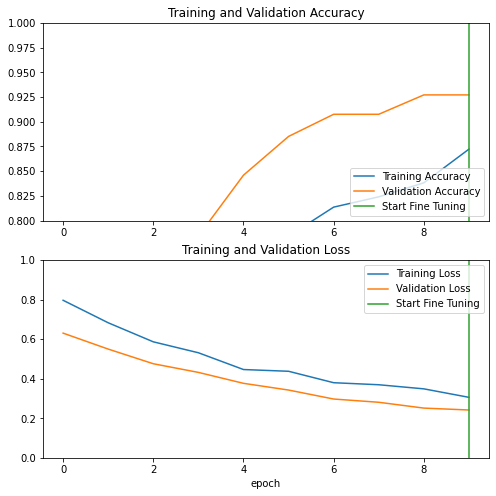

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Some epochs the model works slighty better in the validation sample than in the training sample. This probably happened due to the application of some layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout, which are applied during the training process

In [34]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

34/34 [==============================] - 3s 69ms/step - loss: 0.2245 - accuracy: 0.9347
Test accuracy : 0.9375
Train accuracy : 0.9347209334373474


4) Fine tune the model

This model is a continuation of the above Model, however, a fine tunning process will be applied in order to increase the performance
During the previos process the weights of the pre-trained network were not updated during the training.
Here we try to increase the performance by applying these weights

4.1) Unfreeze the top layer of the model

In [35]:
base_model.trainable = True

In [36]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


4.2 Compile the model

In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
len(model.trainable_variables)

56

4.3 Train the model

In [39]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
34/34 [==============================] - 9s 130ms/step - loss: 0.1466 - accuracy: 0.9508 - val_loss: 0.0413 - val_accuracy: 0.9916
Epoch 11/15
34/34 [==============================] - 4s 112ms/step - loss: 0.0694 - accuracy: 0.9754 - val_loss: 0.0497 - val_accuracy: 0.9916
Epoch 12/15
34/34 [==============================] - 4s 110ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0262 - val_accuracy: 0.9916
Epoch 13/15
34/34 [==============================] - 4s 110ms/step - loss: 0.0326 - accuracy: 0.9905 - val_loss: 0.0264 - val_accuracy: 0.9860
Epoch 14/15
34/34 [==============================] - 4s 113ms/step - loss: 0.0350 - accuracy: 0.9886 - val_loss: 0.0317 - val_accuracy: 0.9944
Epoch 15/15
34/34 [==============================] - 4s 111ms/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0268 - val_accuracy: 0.9916


In [40]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

4.4 Results

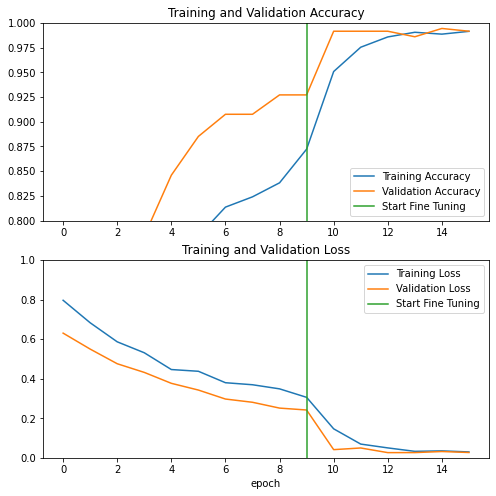

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

12/12 [==============================] - 1s 34ms/step - loss: 0.0249 - accuracy: 0.9916
Test accuracy : 0.9895833134651184
Train accuracy : 0.9971618056297302
Validation accuracy : 0.9915966391563416


As it can be seen in the training and testsamples the accuracy is really high, greater than 0.99, hence this model is robust and works really well

5) Prediction

Doing prediction

Predictions:
 [0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
Labels:
 [0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]


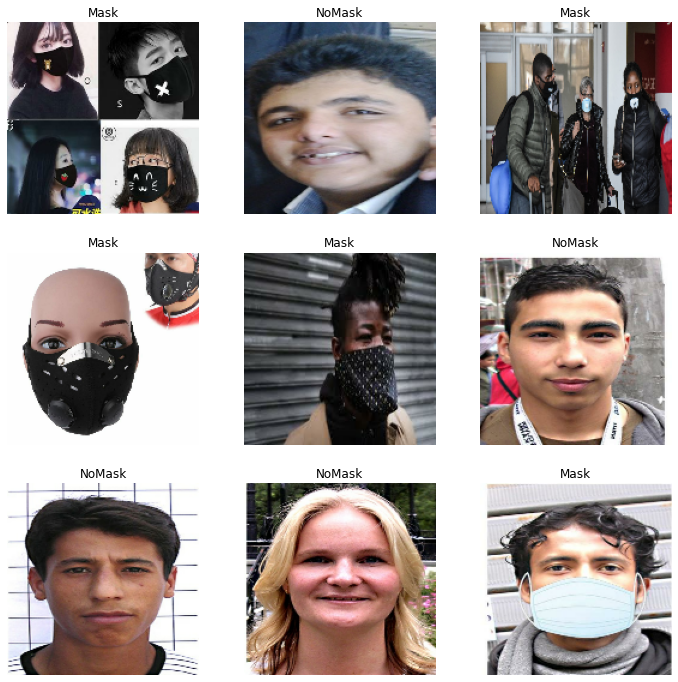

In [43]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

As per the results, it looks like that the model classified correctly on the images, it can be seen that the array of Predictions is the same as Labels

Try to predict with my own image

0
MyImage/1.jpg
tf.Tensor(0.992677, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int32)
1
MyImage/2.jpg
tf.Tensor(0.005520925, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)
2
MyImage/3.jpg
tf.Tensor(0.034650058, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)


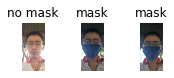

In [44]:
from keras.preprocessing import image

ImageDir = "MyImage/"
ran_num = []
plt.figure(figsize=(3, 3))

for i in range(3):
    ax= plt.subplot(3, 3, i + 1)
    print(i)
    imagePath = ImageDir + str(i+1) + ".jpg"
    print(imagePath)
    plt.imshow(mpimg.imread(imagePath))
    test_image = image.load_img(imagePath, target_size = (160, 160))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    prediction = tf.nn.sigmoid(result[0][0])
    print(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    print(prediction)
    #training_set.class_names

    
    if prediction == 0:
      plt.title("mask")
    else:
      plt.title("no mask")
    plt.axis("off")




Save the model in h5. So that can deploy this on to web or AWS to be used.

In [45]:
model.save("Model/mask_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
